# Some basic plots with matplotlib and pandas

Pandas is an open source Python library for data analysis. It introduces two new data structures to Python - Series and DataFrame, both of which are built on top of NumPy (this means it's fast).
- [Series](http://pandas.pydata.org/pandas-docs/version/0.15.2/dsintro.html#basicsseries) is a one-dimensional labeled array capable of holding any data type (integers, strings, floating point numbers, Python objects, etc.). 
- [DataFrame](http://pandas.pydata.org/pandas-docs/version/0.15.2/dsintro.html#basics-dataframe) is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects.

Pandas is also tightly integrated with [matplotlib](http://pandas.pydata.org/pandas-docs/version/0.15.2/visualization.html) and you do basic plotting directly from a dataframe.

For this exercise we will use downscaled climate projections for maximum temperature and precipitation from the [Cal-Adapt API](http://beta.cal-adapt.org/)

In [2]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline
from pprint import pprint
from urllib.parse import urljoin

try:
    import requests 
    import json
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    print('Some required Python modules are missing.')
    
# Setting headers for HTTP request, Cal-Adapt API provides data in json, csv, geotiff formats. We will use json.
headers = {'ContentType': 'json'}

# entry point of the API
api = 'http://api.cal-adapt.org/api/'

### Let's look at data for Sacramento County

If you open [this link](http://api.cal-adapt.org/api/), you can see a list of resources currently available through the api. The list of climate datasets is under `series`. You can pass in your own geometry to query the climate data or use geometry available through the api. For this exercise we will use the `counties` resource available through the Cal-Adapt api. 

The code below gets the `id` for the polygon feature (Sacramento County) by querying the `counties` resource.

In [3]:
resource = 'counties'
params = {'name': 'Sacramento'}

# Construct url
url = urljoin(api, resource)

# Get county geometry from api
# Construct a uri string which we will pass to the api later
try:
    response = requests.get(url, params, headers=headers)
    print(response.url)
    json = response.json()
    feature = json['features'][0]
    pprint(feature['properties'])
except requests.exceptions.HTTPError as err:
    print(err)

https://api.cal-adapt.org/api/counties/?name=Sacramento
{'age_10_14': 99820,
 'age_15_19': 105680,
 'age_20_24': 101908,
 'age_25_34': 206646,
 'age_35_44': 190835,
 'age_45_54': 200536,
 'age_55_64': 155637,
 'age_5_9': 98112,
 'age_65_74': 83295,
 'age_75_84': 52193,
 'age_85_up': 23063,
 'age_under5': 101063,
 'ameri_es': 14308,
 'asian': 203211,
 'ave_fam_sz': 3.0,
 'ave_hh_sz': 2.0,
 'ave_sale12': 241559.0,
 'ave_size12': 183.0,
 'black': 147058,
 'cnty_fips': '067',
 'crop_acr12': 105721.0,
 'families': 338982,
 'females': 723995,
 'fhh_child': 49318,
 'fips': '06067',
 'hawn_pi': 13858,
 'hispanic': 306196,
 'households': 513945,
 'hse_units': 555932,
 'hsehld_1_f': 76350,
 'hsehld_1_m': 57076,
 'males': 694793,
 'marhh_chd': 115571,
 'marhh_no_c': 116249,
 'med_age': 34.0,
 'med_age_f': 36.0,
 'med_age_m': 33.0,
 'mhh_child': 18283,
 'mult_race': 93511,
 'name': 'Sacramento',
 'no_farms12': 1352.0,
 'other': 131691,
 'owner_occ': 295482,
 'pop10_sqmi': 1427.0,
 'pop2010': 14187

### Get Maximum Temperature & Precipitation data for HadGEM2-ES model for RCP 8.5 scenario

Url's for resources are hardcoded below, if you want to explore how to get other climate data check out these [Jupyter Notebooks](https://github.com/berkeley-gif/caladapt-public)

In [4]:
temp_url = 'http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp85/events/'
pr_url = 'http://api.cal-adapt.org/api/series/pr_year_HadGEM2-ES_rcp85/events/'

Setup parameters for requesting data

In [5]:
# One way to pass in geometry to Cal-Adapt api is to use the ref parameter
ref = '/api/%s/%s/' % (resource, feature['id'])
print('Uniform Resource Identifier for county: %s' % ref)

# Another way to pass in geometry is to use the g param with spatial boundary in geojson/WKT format.
# For this exercise we will not use this param
g = feature['geometry']

Uniform Resource Identifier for county: /api/counties/34/


The downscaled climate model data in Cal-Adapt has a resolution of aproximately 6 km. So within a county there are multiple 6 km x 6 km grid cells. For this exercise, we don't want the value for each grid cell, we want the mean value for the county. To do this spatial aggregation you can pass a `stat` parameter. The native units are in Kelvin so we will request conversion to Fahrenheit.

In [6]:
# Create params to pass to api
params = {'ref': ref, 'stat': 'mean', 'imperial': True}

Make request for temperature data and create a `Series`

In [7]:
response = requests.get(temp_url, params)
tmaxseries = pd.read_json(response.text, typ='series', orient='split')
print(tmaxseries.head())

2006-12-31 00:00:00+00:00    74.931107
2007-12-31 00:00:00+00:00    78.054192
2008-12-31 00:00:00+00:00    75.509369
2009-12-31 00:00:00+00:00    75.518158
2010-12-31 00:00:00+00:00    74.212547
Name: tasmax_year_HadGEM2-ES_rcp85, dtype: float64


Make request for precipitation data and create a `Series`

In [8]:
response = requests.get(pr_url, params)
prseries = pd.read_json(response.text, typ='series', orient='split')
prseries.head()

2006-12-31 00:00:00+00:00    0.023838
2007-12-31 00:00:00+00:00    0.022522
2008-12-31 00:00:00+00:00    0.038045
2009-12-31 00:00:00+00:00    0.055141
2010-12-31 00:00:00+00:00    0.086447
Name: pr_year_HadGEM2-ES_rcp85, dtype: float64

### Basic line chart

The plot method on Series is just a simple wrapper around a matplotlib function `plt.plot()`

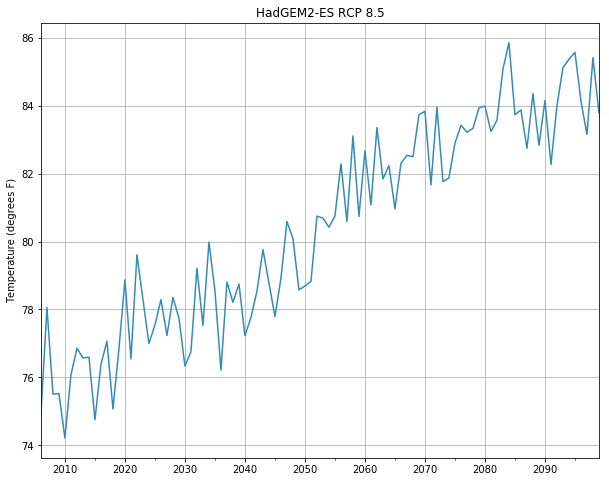

In [40]:
tmaxseries.plot(figsize=(10, 8), color='#348ABD')
plt.title('HadGEM2-ES RCP 8.5')
plt.ylabel('Temperature (degrees F)')
plt.grid(True)

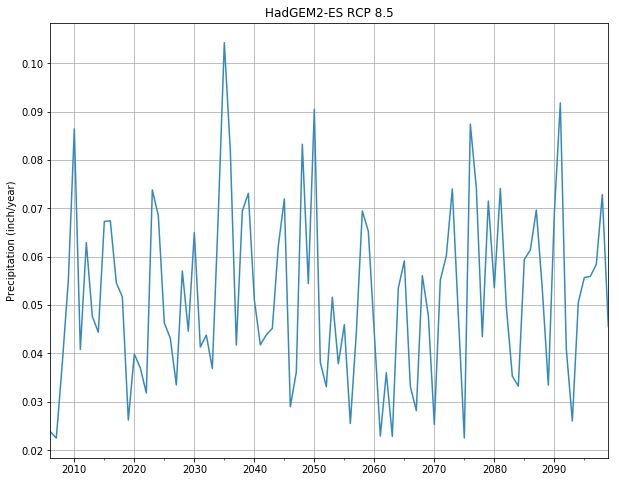

In [39]:
prseries.plot(figsize=(10, 8), color='#348ABD')
plt.title('HadGEM2-ES RCP 8.5')
plt.ylabel('Precipitation (inch/year)')
plt.grid(True)

### A quick histogram

Many many different way to do the same thing ...

Text(0.5,0,'tasmax_year_HadGEM2-ES_rcp85')

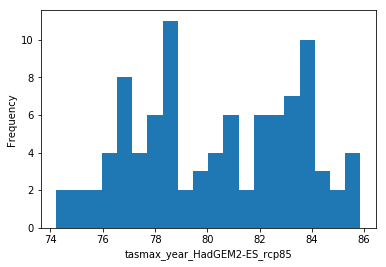

In [43]:
tmaxseries.plot.hist(bins=20)
plt.xlabel(tmaxseries.name)

Introducing [seaborn](http://seaborn.pydata.org/index.html). Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


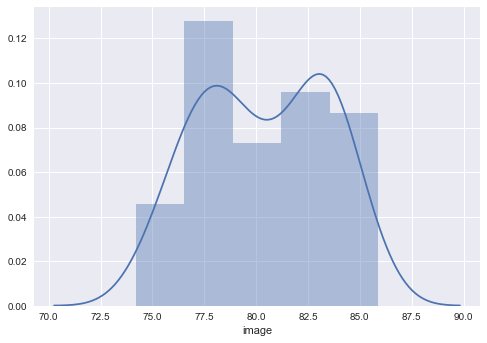

In [16]:
import seaborn as sns

sns.distplot(tmaxseries)
sns.plt.show()

### A quick boxplot

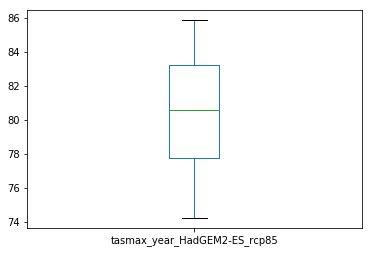

In [44]:
tmaxseries.plot.box()

### Scatterplot

In this example we will use matplotlib directly and pass in the `Series`.

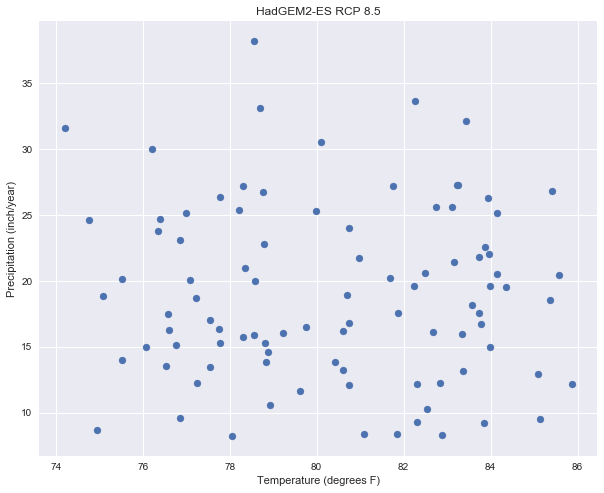

In [18]:
plt.figure(figsize=(10,8)) 
plt.scatter(tmaxseries, prseries)
plt.title('HadGEM2-ES RCP 8.5')
plt.ylabel('Precipitation (inch/year)')
plt.xlabel('Temperature (degrees F)')
plt.grid(True)

Let's use different colors for different time periods (2006-2050 and 2051-2099). One way to do this is to add a new column to a dataframe with the color. Might be better to construct a new dataframe with temperature and precipitation values.

In [46]:
dfT = tmaxseries.to_frame()
dfT['color'] = np.where(dfT.index.year >= 2050, 'red', 'blue')

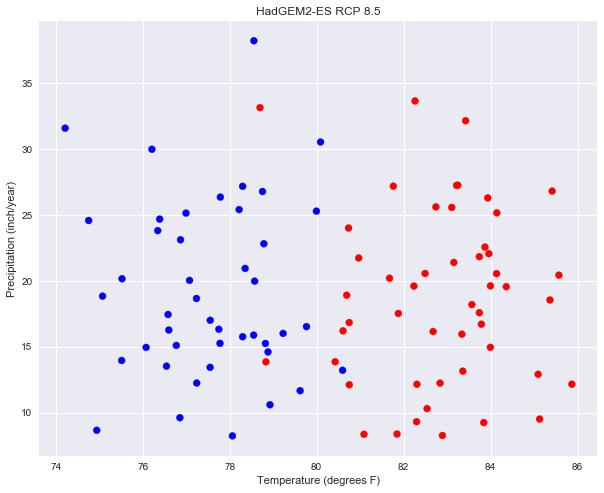

In [20]:
plt.figure(figsize=(10,8)) 
plt.scatter(tmaxseries, prseries, color=dfT['color'])
plt.title('HadGEM2-ES RCP 8.5')
plt.ylabel('Precipitation (inch/year)')
plt.xlabel('Temperature (degrees F)')
plt.grid(True)

Experiment with more examples [here]( http://pandas.pydata.org/pandas-docs/stable/visualization.html)